---
---
# NEURAL NETWORKS AND DEEP LEARNING

### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli

# Homework 1 - Supervised Deep Learning
---
---

## Regression task

The goal of this homework is to implement a Neural Network in a Supervised framework to approximate a scalar function $f:\mathbb{R}\to\mathbb{R}$, in which the training and testing points have some noise from a theoretical curve:
$$\hat{y}=f(x) + noise$$

For a proper tune of the hyperparameter, a Grid-Search and a K-Fold cross-validation method are implemented.

In [1]:
#################
#### IMPORTS ####
#################

# Dataframes and Arrays
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold


In [2]:
# Setting the values of the seeds for reproducibility
torch.manual_seed(2012264)    
np.random.seed(2012264)


In [3]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


Training device: cpu


### Dataset and DataLoader 

In [4]:
class CsvDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        self.data = pd.read_csv(csv_file).to_numpy()
        self.names = pd.read_csv(csv_file).columns
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
    

In [5]:
# Remove anything in the data folder
!rm -rf regression_dataset

# DOWNLOADING THE DATA
data_url = "https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/"

# wget without showing the output, I already checked it works
!wget -P regression_dataset {data_url}train_data.csv  #&> /dev/null # download training set
!wget -P regression_dataset {data_url}test_data.csv  #&> /dev/null # download test set


--2022-01-17 00:01:03--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3,7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3,69K  --.-KB/s    in 0s      

2022-01-17 00:01:03 (75,3 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2022-01-17 00:01:03--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3,7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv 

In [6]:
# We only use ToTensor() transform for this task
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset  = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)


Data has been downloaded in the path `./regression_dataset` in two separate csv files: ```./regression_dataset/train_data.csv``` and ```./regression_dataset/test_data.csv``` respectively for the training dataset and testing dataset.


They have been also loaded in RAM as a ```CsvDataset``` class. Let us visualize both training and testing data:

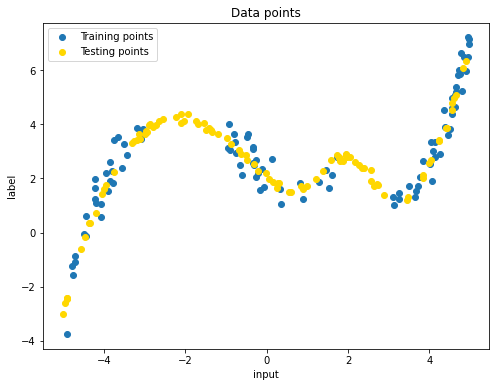

In [7]:
fig = plt.figure(figsize=(8,6))

# Plotting training and test points
plt.scatter(train_dataset.data[:,0], train_dataset.data[:,1], label='Training points')
plt.scatter(test_dataset.data[:,0], test_dataset.data[:,1], label='Testing points', color='gold')

plt.title('Data points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()


Data seems to be generated from a grade-5 polynomial function. It is worth noticing that the training dataset is not optimal, compared to the testing dataset: it is noisier and it has missing values on the two local maxima. The latter will be the most hard problem to overcome, since it requires the model to properly generalize on those two areas it has never been trained on.

### Building the Neural Network Structure

For the Grid-Search I wanted to study different kind of Neural Networks: different number of neurons in the hidden layer and different number of hidden layers too. For this reason the code of the `Net` class has been modified from the Lab.

In [56]:
class Net(nn.Module):
    def __init__(self, Ni, No, Nhs, activation = nn.ReLU(), dropout=0):
        """
        Ni - Input size  (INT)
        No - Output size (INT)
        Nhs - Hidden layers (LIST OF INTEGERS)
        """
        super().__init__()
        nhidden = len(Nhs) # number of hidden layers
        # Creating an array of layers
        Ns = [Ni] + Nhs + [No]
        # First layer
        self.fc1 = nn.Linear(in_features=Ns[0], out_features=Ns[1])
        
        # Hidden layers
        self.hidden = nn.ModuleList()
        for h in range(nhidden-1):
            self.hidden.append(nn.Linear(in_features=Ns[h+1], out_features=Ns[h+2]))
            
        # Last layer
        self.out = nn.Linear(in_features=Ns[-2], out_features=Ns[-1])
        
        self.act = activation
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.act(self.fc1(x))
        
        for h in range(len(self.hidden)):
            x = self.act(self.dropout(self.hidden[h](x)))
        
        x = self.out(x)
        
        return x
    
    def fit(self, data, epochs, folds, torch_loss, printfreq, lr0, reg_term = 0,plotlosses = False):
        # Define the loss function
        loss_fn = torch_loss

        # Define the optimizer
        optimizer = optim.Adam(self.parameters(), lr=lr0, weight_decay= reg_term)
        
        train_loss_log = []
        val_loss_log   = []
        for epoch in range(epochs):
            ### TRAIN
            train_loss = []
    
            self.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
            for sample_batched in data:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)
        
                kf = KFold(n_splits=folds)
                kf.get_n_splits(x_batch)
        
                loss = 0
                for train_index, val_index in kf.split(x_batch):
                    x_batch_train, x_batch_val = x_batch[train_index], x_batch[val_index]
                    y_batch_train, y_batch_val = label_batch[train_index], label_batch[val_index]

                    # Forward pass
                    out = self(x_batch_train)
        
                    # Compute loss
                    loss = loss + loss_fn(out, y_batch_train)/folds

                # Backpropagation
                self.zero_grad()
                loss.backward()

                # Update the weights
                optimizer.step()

                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch)

            # Save average train loss
            train_loss = np.mean(train_loss)
    
            if printfreq!=0 and epoch%printfreq == 0:
                print('#################')
                print(f'# EPOCH {epoch}')
                print('#################')
                print(f"AVERAGE TRAIN LOSS: {train_loss}")
            train_loss_log.append(train_loss)
        
            ### VALIDATION
            val_loss= []
            self.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
            with torch.no_grad(): # Disable gradient tracking
                for sample_batched in data:
                    # Move data to device
                    x_batch = sample_batched[0].to(device)
                    label_batch = sample_batched[1].to(device)

                    kf = KFold(n_splits=folds)
                    kf.get_n_splits(x_batch)
        
                    loss = 0
                    for train_index, val_index in kf.split(x_batch):
                        x_batch_train, x_batch_val = x_batch[train_index], x_batch[val_index]
                        y_batch_train, y_batch_val = label_batch[train_index], label_batch[val_index]

                        # Forward pass
                        out = self(x_batch_val)

                        # Compute loss
                        loss = loss + loss_fn(out, y_batch_val)/folds
                
                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)
        
                # Save average validation loss
                val_loss = np.mean(val_loss)
                if printfreq!=0 and epoch%printfreq == 0:
                    print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
                    print('')
                val_loss_log.append(val_loss)
                
        if plotlosses:
            plt.title('Losses')
            xvalues = np.arange(0,epochs)
            #plt.plot(xvalues, val_loss_log  , label='Validation error')
            plt.plot(xvalues, train_loss_log, label='Training error')
            plt.legend()
            plt.show()
        
        return train_loss_log[-1], val_loss_log[-1]
    
    def show_regression(self,dloader):
        # Input vector
        x_vec = torch.linspace(np.min(dloader.dataset.data[:,0]),
                               np.max(dloader.dataset.data[:,0]),1000)
        x_vec = x_vec.to(device)
        x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector

        self.eval()
        with torch.no_grad(): # turn off gradients computation
            y_vec = self(x_vec)

        # Convert x_vec and y_vec to numpy one dimensional arrays
        x_vec = x_vec.squeeze().cpu().numpy()
        y_vec = y_vec.squeeze().cpu().numpy()

        # Plot output
        plt.plot(x_vec, y_vec, label='Network output',color='red')
        plt.scatter(dloader.dataset.data[:,0], dloader.dataset.data[:,1], label='Training points')

        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        plt.legend()
        plt.show()

    def plot_netweights(self):
        # First hidden layer
        input_weights  = self.fc1.weight.data.cpu().numpy()
        input_biases   = self.fc1.bias.data.cpu().numpy()

        hidden_weights = []
        hidden_biases  = []

        for h in range(len(self.hidden)):
            hidden_weights.append(self.hidden[h].weight.data.cpu().numpy())
            hidden_biases.append(self.hidden[h].bias.data.cpu().numpy())

        output_weights = self.out.weight.data.cpu().numpy()
        output_biases  = self.out.bias.data.cpu().numpy()

        # Weights histogram
        fig, axs = plt.subplots(2+len(self.hidden), 1, figsize=(12,10))
        axs[0].hist(input_weights.flatten(), 50, color='forestgreen')
        axs[0].set_title('First hidden layer weights')
        for h in range(len(self.hidden)):
            axs[h+1].hist(hidden_weights[h].flatten(), 50)
            axs[h+1].set_title('Hidden layer '+str(h+1)+' weights')
        axs[len(self.hidden)+1].hist(output_weights.flatten(), 50, color='orange')
        axs[len(self.hidden)+1].set_title('Output layer weights')
        fig.subplots_adjust(hspace=0.8)
    
        plt.show()
        
    def plot_netactivations(self, xs):
        def get_activation(layer, input, output):
            global activation
            activation = torch.relu(output)
    
        hook_handle = self.hidden[len(self.hidden)-1].register_forward_hook(get_activation)
    
        ### Analyze activations
        net = self.to(device)
        net.eval()
    
        fig, axs = plt.subplots(len(xs), 1, figsize=(12,2*len(xs)))
    
        with torch.no_grad():
            for i, x in enumerate(xs):
                x_act = torch.tensor([x]).float().to(device)
                y_act = best_net(x_act)
                z_act = activation
            
                axs[i].stem(z_act.cpu().numpy(), use_line_collection=True)
                axs[i].set_title('Last layer activations for input x=%.2f' % x)
            
        ### Remove hook
        hook_handle.remove()
    
        plt.tight_layout()
        plt.show()

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size = 100, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size = 100, shuffle=True, num_workers=0)


## Grid-search

In [10]:
# Hyperparameters for the gridsearch:
grid_lrs = [1e-3]
grid_losses = [nn.MSELoss()] #nn.L1Loss(),
grid_regs = [1e-4]
grid_hlayers = [[500,500,500]]
grid_dropouts = [.02]
grid_activations = [nn.Tanh()]

best_train_loss = 1000000
best_val_loss   = 1000000

i = 0

for grid_lr in grid_lrs:
    for grid_loss in grid_losses:
        for grid_reg in grid_regs:
            for grid_hlayer in grid_hlayers:
                for grid_dropout in grid_dropouts:
                    for grid_activation in grid_activations:
                        # For every possible combination of hyperparameters...
                        grid_net = Net(1,1,grid_hlayer,activation = grid_activation, dropout=grid_dropout)
                        grid_train_loss, grid_val_loss = grid_net.fit(train_dataloader,1,3,
                                                             grid_loss,0,grid_lr,reg_term = grid_reg)
                
                        if grid_val_loss < best_val_loss:
                            best_val_loss = grid_val_loss
                    
                            # Save the best combination of the hyperparameters in a dictionary
                            # so we can inspect the best model later
                            best_config = {
                              "lr":            grid_lr,
                              "loss":          grid_loss,
                              "reg":           grid_reg,
                              "hidden layers": grid_hlayer,
                              "dropout":       grid_dropout,
                              "activation":    grid_activation}
                
                            if True: # Set to False, too much useless information displayed
                                print('---------------------')
                                print('Configuration', i)
                                print(' Validation loss: ', grid_val_loss)
                                print(' Lr =           ', grid_lr)
                                print(' Loss =         ', grid_loss)
                                print(' Reg =          ', grid_reg)
                                print(' hidden_layers =', grid_hlayer)
                                print(' dropout =      ', grid_dropout)
                                print(' activation =   ', grid_activation)
                                print('')
                
                        i = i + 1
                

---------------------
Configuration 0
 Validation loss:  7.73878
 Lr =            0.001
 Loss =          MSELoss()
 Reg =           0.0001
 hidden_layers = [500, 500, 500]
 dropout =       0.02
 activation =    Tanh()



In [11]:
print('Best model found: ')
print(best_config)


Best model found: 
{'lr': 0.001, 'loss': MSELoss(), 'reg': 0.0001, 'hidden layers': [500, 500, 500], 'dropout': 0.02, 'activation': Tanh()}


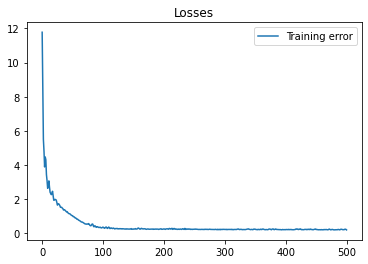

(0.20887889, 0.23313384)

In [57]:
# Initialize and train the model with the best configurations, so we can see how it performs
best_net = Net(1,1,best_config["hidden layers"], activation = best_config["activation"],
          dropout=best_config["dropout"])
best_net.fit(train_dataloader,500,3,best_config["loss"],0,best_config["lr"],
        reg_term = best_config["reg"],plotlosses=True)


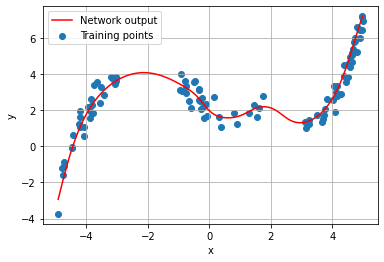

In [58]:
best_net.show_regression(train_dataloader)


### Weight histogram

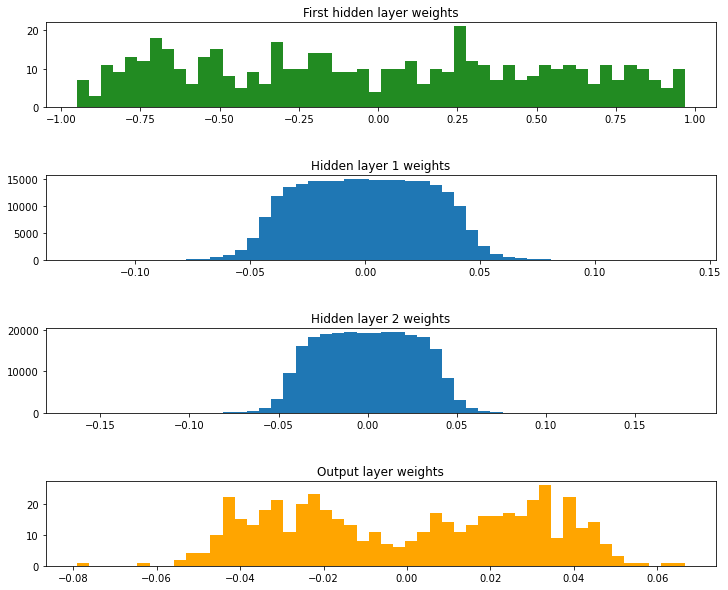

In [14]:
best_net.plot_netweights()

### Activation Profile

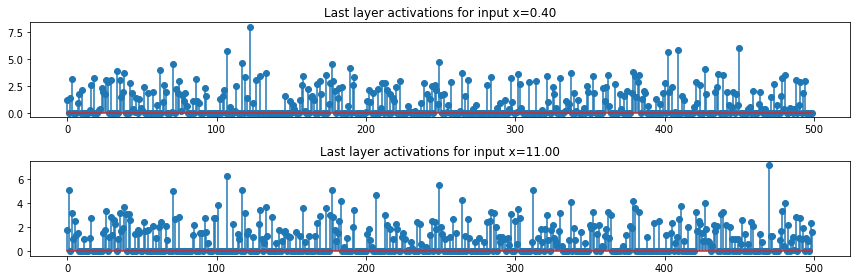

In [59]:
best_net.plot_netactivations([0.4,11])

## Appendix

Here I placed some tests and interesting insights.

### Test: K-Fold Cross-validation

Here is a quick test to check if K-Fold Cross-Validation split was implemented correctly.

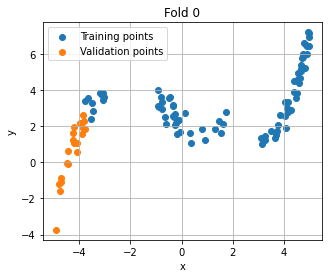

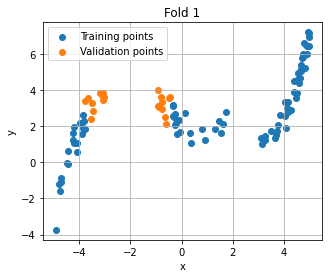

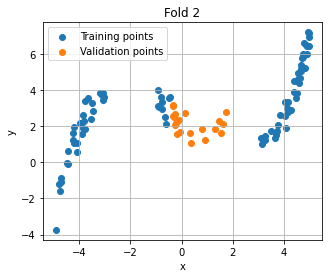

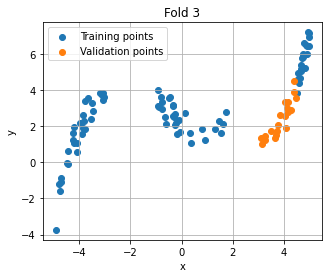

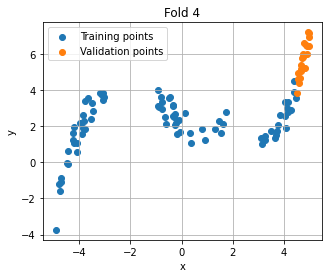

In [16]:
# Create a copy of the data array
kfold_data = train_dataset.data

# Ordering the copy of the data array, so that it's easier to visualize if the kfold worked or not
kfold_data = kfold_data[kfold_data[:,0].argsort()]
k = 0

kf = KFold(n_splits=5)
kf.get_n_splits(kfold_data[:,0])
for train_index, val_index in kf.split(kfold_data[:,0]):
    #print("Fold "+str(k))
    #print("   VAL:", val_index)
    X_train, X_val = kfold_data[:,0][train_index], kfold_data[:,0][val_index]
    y_train, y_val = kfold_data[:,1][train_index], kfold_data[:,1][val_index]
    
    plt.figure(figsize=(5,4))
    plt.title("Fold "+str(k))
    plt.scatter(X_train, y_train, label='Training points')
    plt.scatter(X_val, y_val, label='Validation points')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.legend()
    plt.show()
    k = k + 1
    

In [17]:
# K-Fold seems to be successfully applied, of course for the training of the model, 
# the dataset will be randomly shuffled before


### Polynomial model

In this case the data is cleary generated from a polynomial curve. However it is not always clear the underlying type of model that has generated the data.

Supposing in this case we know for sure (prior knowledge) that data has been generated from a noisy polynomial model, we can try to fit our points with a polynomial curve using the Least Square method.

Focussing on this subclass of models has better performances in training, but a lower generalziation factor.

In [18]:
# y = [a] + [b]x + [c]x^2 + noise
def poly_model(x, beta, noise_std=0):
    """
    INPUT
        x: x vector
        beta: polynomial parameters
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    pol_order = len(beta)
    x_matrix = np.array([x**i for i in range(pol_order)]).transpose()
    #print(x_matrix)
    y = np.matmul(x_matrix, beta)
    noise = np.random.randn(len(y)) * noise_std
    return y + noise

def least_squares(x, y, pol_order, reg_term):
    """
    Implement the least square algorithm to fit a polynomial function of order "pol_order"
    INPUT
        x: training x data
        y: training y data
        pol_order: order of the fitting polynomial function
        reg_term: regularization term
    OUTPUT
        beta_est: estimated parameter vector
    """
    
    # Create the Y matrix
    Y = y.reshape(len(y), 1)
    # Create the X matrix
    X = np.array([x**i for i in range(pol_order+1)]).transpose()
    
    # RLS algorithm
    gram_matrix = np.matmul(X.transpose(), X) + reg_term * np.identity(X.shape[1])
    gram_matrix_inv = np.linalg.inv(gram_matrix)
    temp = np.matmul(gram_matrix_inv, X.transpose())
    beta_est = np.matmul(temp, Y)
    
    return beta_est.squeeze()

def polynomial_model_compute_valerr(params,valset_x,valset_y):
    """
    Computes the MSE of the polinomial found (coefficients) with the testing set
    INPUT
        params: coefficients of the polinomial
        valset_x: x-values of the validation set
        valset_y: y-values of the validation set
    """
    err = 0
    for i in range(len(valset_y)):
        predicted = 0
        for g in range(len(params)):
            predicted = predicted + params[g]*valset_x[i]**g
        err = err + (valset_y[i] - predicted)**2
        
    return np.mean(err)


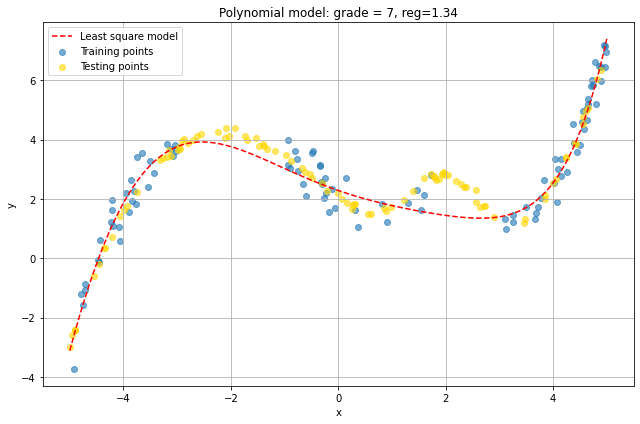

In [19]:
regs = np.linspace(0,20,1000)
lowest_err = 100000
best_reg = 0
best_grade = 0
pgrademax = 8

for reg in regs:
    for pgrade in range(3,pgrademax):
        params = least_squares(train_dataloader.dataset.data[:,0], train_dataloader.dataset.data[:,1], pgrade, reg)
        
        curr_err = polynomial_model_compute_valerr(params,test_dataloader.dataset.data[:,0], test_dataloader.dataset.data[:,1])
    
        if curr_err < lowest_err:
            best_grade = pgrade
            best_reg = reg
            best_betas = params
            lowest_err = curr_err
    
plt.figure(figsize=(9,6))

x_highres = np.linspace(-5,5,1000)
plt.plot(x_highres, poly_model(x_highres, best_betas), color='red', ls='--', label='Least square model')
plt.scatter(train_dataset.data[:,0], train_dataset.data[:,1], label='Training points', alpha=0.6)
plt.scatter(test_dataset.data[:,0], test_dataset.data[:,1], label='Testing points', color='gold', alpha=0.6)

plt.title('Polynomial model: grade = '+str(best_grade)+', reg='+str(round(best_reg,2)))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()